In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
sys.path.append('..')
from tlfair.metrics import *

In [12]:
rng = np.random.default_rng()
n = 10000000
d = 5

x = rng.normal(size=(n,d))
'''
g = (rng.uniform(size = (n,)) > 0.5).astype(np.int8)
for i in range(5):
    x[:,i] = x[:,i] + g
'''

xt = x.copy()
xt = xt**2
'''
for i in range(d):
    xt[:,i] = x[:,i]**2
'''

beta = np.array([4, 2, 1, -3, -4])
y_probs = 1/(1+np.exp(-xt@beta))
y = (y_probs >= 0.5).astype(np.int8)

bg = np.array([1,1,-1,-2,1])
g_probs = 1/(1+np.exp(-xt@bg))
g = (g_probs >= 0.5).astype(np.int8)

print(np.mean(y))
truth = np.mean(y_probs[g==1]) - np.mean(y_probs[g==0])
print(truth)

0.5207495
0.22259700261831766


In [4]:
def robust_sim(
    n,
    propensity = LogisticRegression(solver='liblinear'),
    outcome = LogisticRegression(solver='liblinear')
):

    n = n // 2
    d = 15
    x = rng.normal(size=(2*n,d))
    g = (rng.uniform(size = (2*n,)) > 0.5).astype(np.int8)

    for i in range(5):
        x[:,i] = x[:,i] + g

    xt = x.copy()
    for i in range(10):
        xt[:,i] = x[:,i]**2

    xt[:,10:] = 0
    beta = np.array([4, -6, 1, -3, -4, 1, -3, 4, 4, 1, 0, 0, 0, 0, 0])
    y_probs = 1/(1+np.exp(-xt@beta))
    y = (y_probs >= 0.5).astype(np.int8)

    test = prob_parity(
        xtr = x[:n,:],
        xte = x[n:,:],
        ytr = y[:n],
        yte = y[n:],
        gtr = g[:n],
        gte = g[n:],
        outcome = outcome,
        propensity = propensity,
        )
    return test[0]


In [13]:
def robust_sim_all(
    n,
    truth
):

    n = n // 2
    d = 5
    x = rng.normal(size=(2*n,d))

    xt = x.copy()
    xt = xt**2

    beta = np.array([4, 2, 1, -3, -4])
    y_probs = 1/(1+np.exp(-xt@beta))
    y = (y_probs >= 0.5).astype(np.int8)

    bg = np.array([1,1,-1,-2,1])
    g_probs = 1/(1+np.exp(-xt@bg))
    g = (g_probs >= 0.5).astype(np.int8)

    mis_spec = prob_parity(
        xtr = x[:n,:],
        xte = x[n:,:],
        ytr = y[:n],
        yte = y[n:],
        gtr = g[:n],
        gte = g[n:],
        outcome = LogisticRegression(solver='liblinear'),
        propensity = LogisticRegression(solver='liblinear'),
        )
    
    out_right = prob_parity(
        xtr = x[:n,:],
        xte = x[n:,:],
        ytr = y[:n],
        yte = y[n:],
        gtr = g[:n],
        gte = g[n:],
        outcome = GradientBoostingClassifier(),
        propensity = LogisticRegression(solver='liblinear'),
        )
    
    prop_right = prob_parity(
        xtr = x[:n,:],
        xte = x[n:,:],
        ytr = y[:n],
        yte = y[n:],
        gtr = g[:n],
        gte = g[n:],
        propensity = GradientBoostingClassifier(),
        outcome = LogisticRegression(solver='liblinear'),
        )
    
    both_right = prob_parity(
        xtr = x[:n,:],
        xte = x[n:,:],
        ytr = y[:n],
        yte = y[n:],
        gtr = g[:n],
        gte = g[n:],
        outcome = GradientBoostingClassifier(),
        propensity = GradientBoostingClassifier(),
        )
    
    return mis_spec, out_right, prop_right, both_right

In [14]:
def robust_exp(sample_sizes, reps):
    rng = np.random.default_rng()
    n = 10000000
    d = 5
    x = rng.normal(size=(n,d))

    xt = x.copy()
    xt = xt**2

    beta = np.array([4, 2, 1, -3, -4])
    y_probs = 1/(1+np.exp(-xt@beta))
    y = (y_probs >= 0.5).astype(np.int8)

    bg = np.array([1,1,-1,-2,1])
    g_probs = 1/(1+np.exp(-xt@bg))
    g = (g_probs >= 0.5).astype(np.int8)
    truth = np.mean(y_probs[g==1]) - np.mean(y_probs[g==0])
    res = pd.DataFrame()
    
    cases = [
        'misspecified',
        'outcome_correct',
        'propensity_correct',
        'both_correct'
    ]

        
    for i in range(len(sample_sizes)):
        data = dict()
        for c in cases:
            data[c] = dict()
            data[c]['coverage'] = 0
            data[c]['estimates'] = []
        for _ in range(reps):
            hold = robust_sim_all(n=sample_sizes[i], truth=truth)
            for k in range(len(cases)):
                c = cases[k]
                data[c]['estimates'].append(hold[k][0])
                if hold[k][1][0] <= truth and hold[k][1][1] >= truth:
                    data[c]['coverage'] += 1/reps
            
        for k in range(len(cases)):
            c = cases[k]
            tmpdf = pd.DataFrame({
                'cases' : [c],
                'sample_size' : [sample_sizes[i]],
                'coverage' : [data[c]['coverage']],
                '95-percentile' : [np.quantile(data[c]['estimates'], 0.95)],
                '5-percentile' : [np.quantile(data[c]['estimates'], 0.05)],
                'mean_estimate' : [np.mean(data[c]['estimates'])],
                'error' : [np.mean(data[c]['estimates']) - truth]
            })
            res = pd.concat([res, tmpdf])
    return res

In [18]:
res = robust_exp([250,500,1000,2500], reps=100)

In [25]:
res
#res.to_csv('../robust_res.csv')

Text(0.5, 23.52222222222222, 'Sample Size')

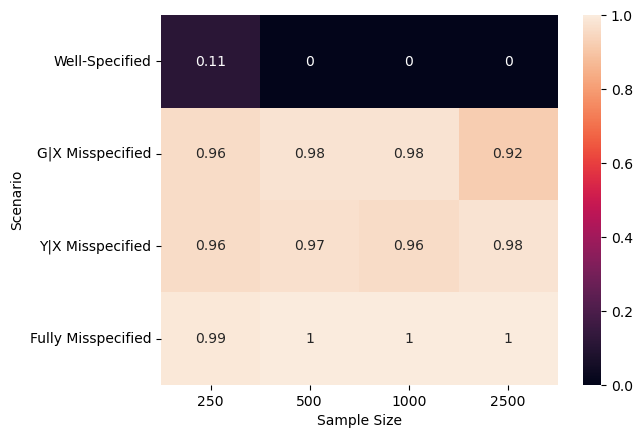

In [3]:
res = pd.read_csv('../robust_res.csv')
res['cases'] = pd.Categorical(
    res['cases'], 
    ['misspecified', 
     'outcome_correct', 
     'propensity_correct', 
     'both_correct'])
plot = res.pivot(index='cases', columns='sample_size', values='coverage')
#plt.figure(figsize=(10, 4))
ax = sns.heatmap(plot, annot=True)
ax.set_yticklabels(['Well-Specified', 'G|X Misspecified', 'Y|X Misspecified', 'Fully Misspecified'])
ax.set_ylabel('Scenario')
ax.set_xlabel('Sample Size')